Processing information need 1...
Processing system Enhanced System...
Processing system New Schema System...
Processing system Synonyms System...
Processing system Keywords System...
Processing system Embeddings System...


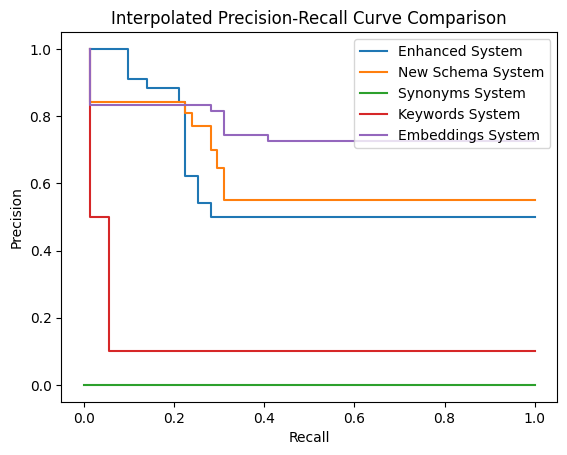

0             System  Average Precision  Precision at 10 (P@10)
1    Enhanced System           0.858932                     0.9
1  New Schema System           0.777723                     0.8
1    Synonyms System           0.000000                     0.0
1    Keywords System           0.565476                     0.4
1  Embeddings System           0.774552                     0.7
Processing information need 2...
Processing system Enhanced System...
Processing system New Schema System...
Processing system Synonyms System...
Processing system Keywords System...
Processing system Embeddings System...


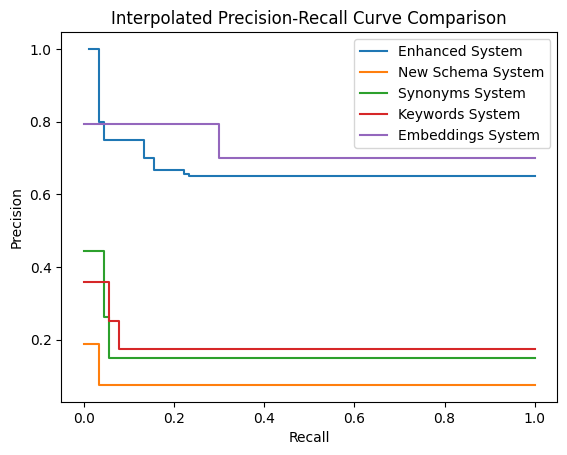

0             System  Average Precision  Precision at 10 (P@10)
1    Enhanced System           0.707906                     0.7
1  New Schema System           0.140422                     0.0
1    Synonyms System           0.303251                     0.4
1    Keywords System           0.254040                     0.2
1  Embeddings System           0.700967                     0.6
Processing information need 3...
Processing system Enhanced System...
Processing system New Schema System...
Processing system Synonyms System...
Processing system Keywords System...
Processing system Embeddings System...


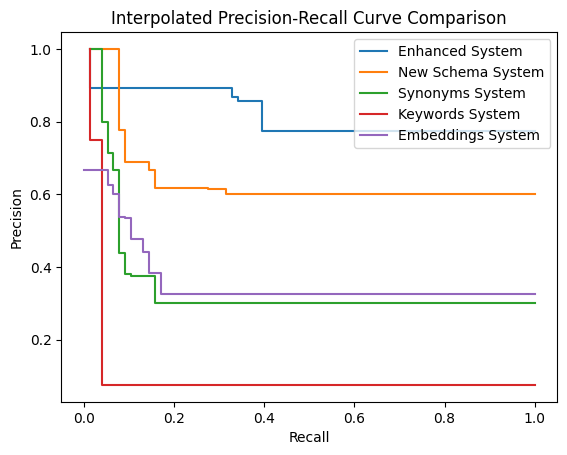

0             System  Average Precision  Precision at 10 (P@10)
1    Enhanced System           0.845534                     0.8
1  New Schema System           0.716314                     0.7
1    Synonyms System           0.616292                     0.6
1    Keywords System           0.805556                     0.3
1  Embeddings System           0.529027                     0.6
Processing information need 4...
Processing system Enhanced System...
Processing system New Schema System...
Processing system Synonyms System...
Processing system Keywords System...
Processing system Embeddings System...


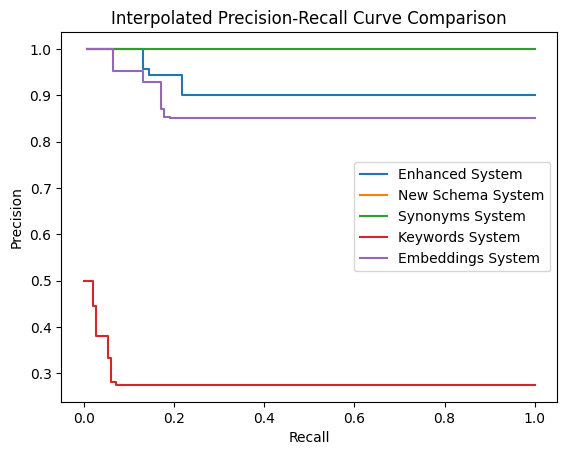

0             System  Average Precision  Precision at 10 (P@10)
1    Enhanced System           0.968378                     1.0
1  New Schema System           1.000000                     1.0
1    Synonyms System           1.000000                     1.0
1    Keywords System           0.385366                     0.4
1  Embeddings System           0.931871                     1.0


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd
import os

# Helper function to sanitize query names for filenames
def sanitize_query(query):
    return query.replace(' ', '_')

# Read configuration from JSON file
with open('../queries.json', 'r') as config_file:
    config = json.load(config_file)

# METRICS TABLE
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    precision_values = []
    relevant_count = 0

    for idx, doc in enumerate(results):
        if doc['book_id'] in relevant:
            relevant_count += 1
            precision_at_k = relevant_count / (idx + 1)
            precision_values.append(precision_at_k)

    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

@metric
def p10(results, relevant, n=10):
    return len([doc for doc in results[:n] if doc['book_id'] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

# Container for results data
all_results_data = []

# Counter for assigning IDs
id_counter = 1

# create a mapping for the system names with _ and the pretty names
system_names = [
    
    # "Base System",
    "Enhanced System",
    "New Schema System",
    "Synonyms System",
    "Keywords System",
    "Embeddings System",
    # "Combinated System",

]

for info_need in config['information_needs']:
    print(f'Processing information need {id_counter}...')
    query = info_need['query']
    sanitized_query = sanitize_query(query)
    qrels_file = info_need['qrels_file']
    folder_name = f'IN_{id_counter}/results'

    # Create a directory for results
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    else:
        # delete all files in the directory
        files = os.listdir(folder_name)
        for file in files:
            os.remove(os.path.join(folder_name, file))
        

    relevant = list(map(lambda el: int(el.strip()), open(qrels_file).readlines()))

    results_data = []

    # create a data frame for the relevance with columns rank from 1 to 40 and a column for each system
    relevance_df = pd.DataFrame(columns=['Rank'])
    relevance_df['Rank'] = range(1, 41)
    

    for system in info_need['systems']:
        

        if system['name'] in system_names:
            print(f'Processing system {system["name"]}...')
            system_name = system['name']
            query_url = system['query_url']
            
            if system_name == "Embeddings System":
                # load results from json file
                with open(f'../embeddings/results/IN_{id_counter}.json', 'r') as f:
                    results = json.load(f)['response']['docs']
            else:
                results = requests.get(query_url).json()['response']['docs']


            # Calculate metrics and export results
            df = pd.DataFrame([['Metric', 'Value']] +
                            [[evaluation_metrics[m], calculate_metric(m, results, relevant)] for m in evaluation_metrics])

            # export dataframe to latex
            with open(f'{folder_name}/{system_name}.tex', 'w') as tf:
                tf.write(df.to_latex())
            with open(f'{folder_name}/{system_name}.csv', 'w') as tf:
                tf.write(df.to_csv())

            results_data.append((id_counter, system_name, results))

            # create a dataframe with columns rank and relevance current system
            df = pd.DataFrame(columns=['Rank', system_name])
            df['Rank'] = range(1, 41)

            # calculate the relevance for each document
            for idx, doc in enumerate(results):
                if doc['book_id'] in relevant:
                    df.loc[idx, system_name] = "R"
                else:
                    df.loc[idx, system_name] = "NR"
            

            # add the relevance column to the relevance dataframe
            relevance_df = pd.merge(relevance_df, df, on='Rank', how='outer')

    # export relevance dataframe to latex
    relevance_df.to_latex(f'{folder_name}/IN_{id_counter}_relevance.tex', index=False, header=True)

    all_results_data.append((id_counter, query, results_data))
    

    # Combine results for precision-recall curve comparison
    fig, ax = plt.subplots()

    for _, system_name, results in results_data:
        precision_values = [len([doc for doc in results[:idx+1] if doc['book_id'] in relevant]) / (idx+1) for idx, _ in enumerate(results)]
        recall_values = [len([doc for doc in results[:idx+1] if doc['book_id'] in relevant]) / len(relevant) for idx, _ in enumerate(results)]

        decreasing_max_precision = np.maximum.accumulate(precision_values[::-1])[::-1]
        precision_recall_match = list(zip(recall_values, decreasing_max_precision))

        if recall_values[-1] != 1:
            precision_recall_match.append((1, precision_values[-1]))

        plt.plot(*zip(*precision_recall_match), label=f'{system_name}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Interpolated Precision-Recall Curve Comparison')
    plt.legend()
    plt.savefig(f'{folder_name}/IN_{id_counter}_precision_recall_comparison.png')
    plt.show()
    plt.close()

    # Compare metrics in a table
    merged_dfs = []

    for _, system_name, _ in results_data:
        system_df = pd.read_csv(f'{folder_name}/{system_name}.csv', index_col=0)
        system_df = system_df.T
        system_df.columns = system_df.iloc[0]
        system_df = system_df.drop(system_df.index[0])
        merged_dfs.append(system_df)

    comparison_df = pd.concat(merged_dfs)
    comparison_df['System'] = [f'{system_name}' for _, system_name, _ in results_data]
    comparison_df = comparison_df[['System', 'Average Precision', 'Precision at 10 (P@10)']]
    comparison_df['Average Precision'] = comparison_df['Average Precision'].astype(float)
    comparison_df['Precision at 10 (P@10)'] = comparison_df['Precision at 10 (P@10)'].astype(float)

    # Print and export the comparison table
    print(comparison_df)
    with open(f'{folder_name}/IN_{id_counter}_comparison.tex', 'w') as tf:
        tf.write(comparison_df.to_latex(index=False, escape=False, float_format="%.6f"))

    id_counter += 1
# Store all_results_data for later use if needed
